
**Purpose**: This notebook explores the use of daily RAIN rate (mm/s) provided by the CMIP6 model to identify ArkStorm precipitation conditions. Precipitation conditions are defined as conditions in which precipitation, in the form of quantity and total days of rainfall, with sufficient influx that could result in an ArkStorm. This is used as an indicator for time periods that require futher investigation into ArkStorm conditions.

Slice the dataset through time so we're working with less data. Choosing the time range of 1861 - 1862 to see if we can identify the conditions for the ArkStorm event that took place during this time.

>What Caused the Great Flood of 1862?
The Great Flood of 1862 was the largest recorded flood in the history of California, Nevada, and Oregon. It occurred following several weeks of continuous **rain and snow that began in Oregon in November of 1861 and continued into January 1862**.These weather conditions contributed to flooding that spanned from the Columbia River in western Oregon to the city of San Diego, over 1,000 miles away, and also impacted a handful of interior states. The devastation was widespread and in California:
>
>- 4,000 people died
>
>- 1/3 of property was destroyed
>
>- 200,000 heads of cattle, or 25% of the state’s total, wiped out
>
>- The state went bankrupt, with state employees unable to be paid for 18 months
>
>- Inflation saw the price of eggs rise to 3 dollars per dozen, or 79 dollars in today’s dollars
>
> 
>California state legislators had to row to work at the Capital in Sacramento for several weeks before temporarily relocating to San Francisco, so that much of the city could be raised on average 10 feet. You can still visit the “underground city” if you ever visit Old Town Sacramento.
 

In [1]:
import intake
import numpy as np
import geopandas as gpd
import rioxarray
from dask.distributed import Client
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.dates as mdates

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:60184,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:60196,Total threads: 3
Dashboard: http://127.0.0.1:60199/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:60187,


## 1. CESM2 Data

In [3]:
# List the data available in the Intake Catalog
catalog = intake.open_esm_datastore(
    'https://raw.githubusercontent.com/NCAR/cesm2-le-aws/main/intake-catalogs/aws-cesm2-le.json'
)

**CESM2 variables that are related to precipitation**

- PRECC                convective precipitation rate (liq + ice)  
- PRECL                large-scale (stable) precipitation rate (liq + ice)  
- PRECSC               convective snow rate (water equivalent)  
- PRECSL               large-scale (stable) snow rate (water equivalent)  
- RAIN                 atmospheric rain, after rain/snow repartitioning based on temperature  
- SNOW                 atmospheric snow, after rain/snow repartitioning based on temperature  

- *TMQ                  total (vertically integrated) precipitable water*  
    *This is all the possible precipitable water in the atmospheric column, if it turned into rain*   

- QRUNOFF              total liquid runoff not including correction for land use change  


In [4]:
catalog_subset = catalog.search(variable='RAIN', frequency='daily')
catalog_subset.df

,variable,long_name,component,experiment,forcing_variant,frequency,vertical_levels,spatial_domain,units,start_time,end_time,path
0,RAIN,"atmospheric rain, after rain/snow repartitioni...",lnd,historical,cmip6,daily,1.0,global_land,mm/s,1850-01-01 12:00:00,2014-12-31 12:00:00,s3://ncar-cesm2-lens/lnd/daily/cesm2LE-histori...
1,RAIN,"atmospheric rain, after rain/snow repartitioni...",lnd,historical,smbb,daily,1.0,global_land,mm/s,1850-01-01 12:00:00,2014-12-31 12:00:00,s3://ncar-cesm2-lens/lnd/daily/cesm2LE-histori...
2,RAIN,"atmospheric rain, after rain/snow repartitioni...",lnd,ssp370,cmip6,daily,1.0,global_land,mm/s,2015-01-01 12:00:00,2100-12-31 12:00:00,s3://ncar-cesm2-lens/lnd/daily/cesm2LE-ssp370-...
3,RAIN,"atmospheric rain, after rain/snow repartitioni...",lnd,ssp370,smbb,daily,1.0,global_land,mm/s,2015-01-01 12:00:00,2100-12-31 12:00:00,s3://ncar-cesm2-lens/lnd/daily/cesm2LE-ssp370-...


Load the CMIP6 historical experiment.

In [5]:
# return a dictionary of the datasets in the catalog_subset
dsets = catalog_subset.to_dataset_dict(storage_options={'anon':True})

# load the historical cmip predictions
historical_cmip6 = dsets['lnd.historical.daily.cmip6']
historical_cmip6


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency.forcing_variant'


<xarray.Dataset> Size: 533GB
Dimensions:      (member_id: 40, time: 60225, lat: 192, lon: 288,
                  hist_interval: 2)
Coordinates:
  * lat          (lat) float32 768B -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * lon          (lon) float32 1kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * member_id    (member_id) <U12 2kB 'r10i1231p1f1' ... 'r9i1301p1f1'
  * time         (time) object 482kB 1850-01-01 12:00:00 ... 2014-12-31 12:00:00
    time_bounds  (time, hist_interval) object 964kB dask.array<chunksize=(30113, 1), meta=np.ndarray>
Dimensions without coordinates: hist_interval
Data variables:
    RAIN         (member_id, time, lat, lon) float32 533GB dask.array<chunksize=(1, 730, 192, 288), meta=np.ndarray>
Attributes: (12/115)
    Conventions:                               CF-1.0
    Initial_conditions_dataset:                arbitrary initialization
    PFT_physiological_constants_dataset:       clm5_params.c171117.nc
    Surface_dataset:                           surfdata_0.9x1.25_hist_78pfts_...
    Time_constant_3Dvars:                      ZSOI:DZSOI:WATSAT:SUCSAT:BSW:H...
    Time_constant_3Dvars_filename:             ./b.e21.BHISTcmip6.f09_g17.LE2...
    ...                                        ...
    intake_esm_attrs:units:                    mm/s
    intake_esm_attrs:start_time:               1850-01-01 12:00:00
    intake_esm_attrs:end_time:                 2014-12-31 12:00:00
    intake_esm_attrs:path:                     s3://ncar-cesm2-lens/lnd/daily...
    intake_esm_attrs:_data_format_:            zarr
    intake_esm_dataset_key:                    lnd.historical.daily.cmip6

## 2. Study Area

The study area for this analysis is California. The following cells plot this area and identify the CMIP6 grid cells that we'll need in for our analysis.

We need to define the bounding box for our study area using standard lat/lon notation as well as degrees-east and degree-west. 

In [6]:
# bounding box in lat lon
bbox_lat_lon = [-124.0,32.0,-114.0,43.0]

# bounding box in degrees-west (from CMIP6 dataset).
# this is used to subset CMIP6 data
bbox_deg_west = [180 + bbox_lat_lon[0], bbox_lat_lon[1],
                 180 + bbox_lat_lon[2], bbox_lat_lon[3]]

# convert the longitudes in our dataset from degrees-west into degrees ranging from -180 to 180 
# this is necessary so that they align properly with our vector data.
historical_cmip6['lon'] = historical_cmip6.lon - 180

# bounding box in degrees-east
# this is used for plotting
bbox_deg_east = [360 + bbox_lat_lon[0], bbox_lat_lon[1],
                 360 + bbox_lat_lon[2], bbox_lat_lon[3]]

Load a vector layer of the USA.

In [7]:
# Load the sample dataset of the USA states from geopandas
usa = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Filter the dataset for the USA
usa_states = usa[usa['iso_a3'] == 'USA']

# Load the US states from an online source
states_url = 'https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json'
states = gpd.read_file(states_url)

/var/folders/6l/9spwppmn3gxfld10q9_szx5h0000gp/T/ipykernel_25062/1494385309.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  usa = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


Subset our domain so that we only include cells that intersect with the state of California.

In [8]:
geom = states[states.name == 'California']
geom.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Set the CRS in the xarray dataset. I'm assuming this is WGS 1984 because it's in decimal degrees and no other information was found on the CESM2 website.

In [9]:
historical_cmip6.rio.write_crs("epsg:4326", inplace=True)
historical_cmip6.rio.set_spatial_dims('lon', 'lat')
historical_cmip6.rio.crs.to_wkt()

'GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'

Clip the xarray dataset so that it only contains data within Califorina.

In [10]:
# clip the data
cmip = historical_cmip6.rio.clip(
         geom.geometry.values,
         geom.crs,
         all_touched=True,   # select all grid cells that touch the vector boundary
         drop=True,          # drop anything that is outside the clipped region
         invert=False,
         from_disk=True)
cmip

<xarray.Dataset> Size: 1GB
Dimensions:      (lat: 11, lon: 10, member_id: 40, time: 60225)
Coordinates:
  * lat          (lat) float32 44B 32.51 33.46 34.4 35.34 ... 40.05 40.99 41.94
  * lon          (lon) float32 40B -125.0 -123.8 -122.5 ... -116.2 -115.0 -113.8
  * member_id    (member_id) <U12 2kB 'r10i1231p1f1' ... 'r9i1301p1f1'
  * time         (time) object 482kB 1850-01-01 12:00:00 ... 2014-12-31 12:00:00
    spatial_ref  int64 8B 0
Data variables:
    RAIN         (member_id, time, lat, lon) float32 1GB dask.array<chunksize=(1, 730, 11, 10), meta=np.ndarray>
Attributes: (12/115)
    Conventions:                               CF-1.0
    Initial_conditions_dataset:                arbitrary initialization
    PFT_physiological_constants_dataset:       clm5_params.c171117.nc
    Surface_dataset:                           surfdata_0.9x1.25_hist_78pfts_...
    Time_constant_3Dvars:                      ZSOI:DZSOI:WATSAT:SUCSAT:BSW:H...
    Time_constant_3Dvars_filename:             ./b.e21.BHISTcmip6.f09_g17.LE2...
    ...                                        ...
    intake_esm_attrs:units:                    mm/s
    intake_esm_attrs:start_time:               1850-01-01 12:00:00
    intake_esm_attrs:end_time:                 2014-12-31 12:00:00
    intake_esm_attrs:path:                     s3://ncar-cesm2-lens/lnd/daily...
    intake_esm_attrs:_data_format_:            zarr
    intake_esm_dataset_key:                    lnd.historical.daily.cmip6

2024-08-27 11:50:10,240 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


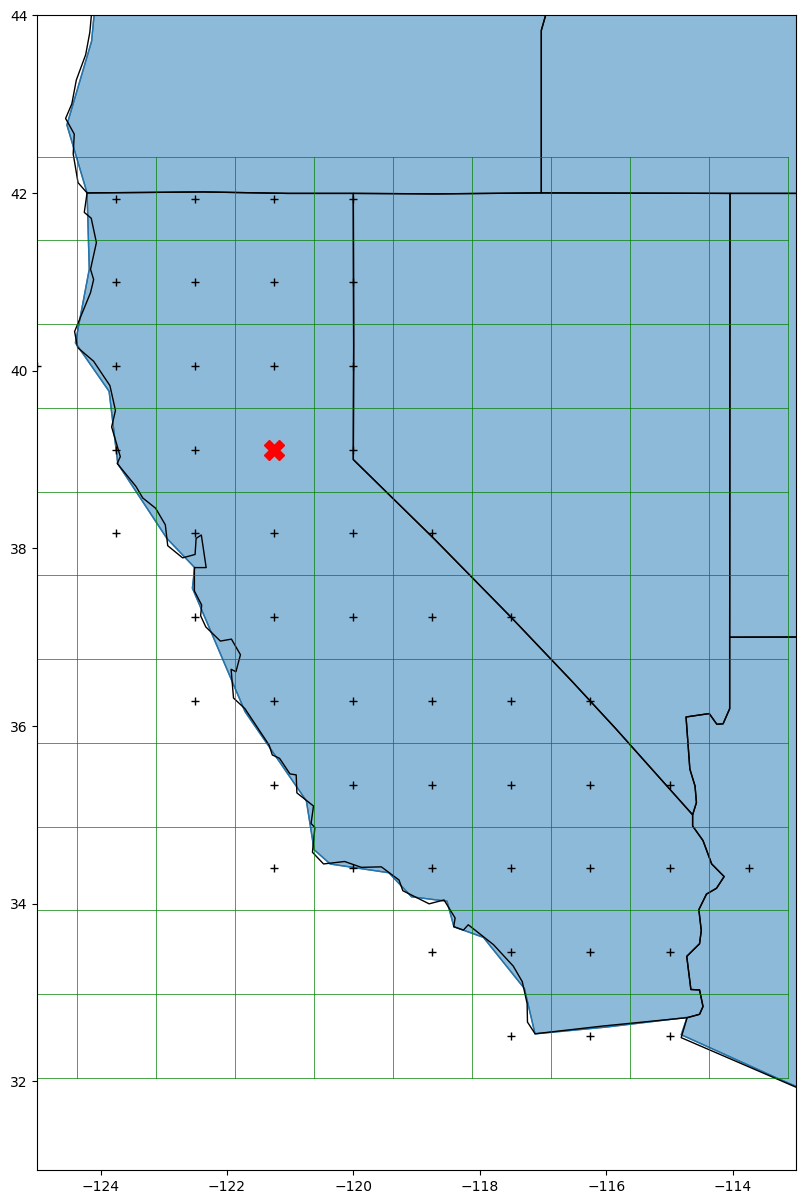

In [152]:
# Plot the USA states
fig, ax = plt.subplots(1, 1, figsize=(10, 15))
usa_states.boundary.plot(ax=ax, linewidth=1)
usa_states.plot(ax=ax, alpha=0.5, edgecolor='k')
states.boundary.plot(ax=ax, linewidth=1, color='k', label='State Boundaries')

# Plot latitudinal and longitudinal grid lines from the CMIP6 dataset
lon_offset = np.diff(cmip.lon.values)[0] / 2
lat_offset = np.diff(cmip.lat.values)[0] / 2

lons = [lo-lon_offset for lo in cmip.lon.values] + [cmip.lon.values[-1] + lon_offset]
lats = [la-lat_offset for la in cmip.lat.values] + [cmip.lat.values[-1] + lat_offset]

# add grid lines
for la in cmip.lat:
    ax.plot(lons, [la-lat_offset]*len(lons), color='green', linewidth=0.5)
ax.plot(lons, [la+lat_offset]*len(lons), color='green', linewidth=0.5)

for lo in lons:
    ax.plot([lo]*len(lats), lats, color='green', linewidth=0.5)

# determine where data exists (and doesn't exist) in the cmip dataset.
# TODO: combine this with the clip operation above.
from rasterio.features import geometry_mask
mask = geometry_mask(
    geom.geometry.values,
    transform=cmip.rio.transform(),
    invert=True,
    all_touched=True,
    out_shape=cmip.rio.shape)

# # add grid cell centroids
# # Only add the centroid if the value in the mask is True. This
# # way we're only showing locations where data exists in our cmip dataset.
for j in range(0, len(cmip.lat)):
    la = cmip.lat[j]
    for i in range(0, len(cmip.lon)):
        lo = cmip.lon[i]
        if mask[j][i]:
            ax.plot(lo, la, color='black', marker='+')
        
# adjust the figure axis to the extent of our study area
plt.xlim(bbox_lat_lon[0]-1, bbox_lat_lon[2]+1)
plt.ylim(bbox_lat_lon[1]-1, bbox_lat_lon[3]+1)

i = 3
j = 7
xlon = cmip.isel(lon=i).lon.item()
ylat = cmip.isel(lat=j).lat.item()
ax.plot(xlon, ylat, color='red', marker='X', markersize=14)

plt.show()

In [12]:
# slice cmip predictions for a period in which a know ArkStorm has occurred.
cmip_1800 = cmip.sel(time=slice('1861-01-01', '1862-12-31'))

The CESM2 Large Ensemble dataset consists of many members. The CMIP6 predictions that we selected above contain 40-members. These are explained as:

> Members 1-10: These will begin from years 1001, 1021, 1041, 1061, 1081, 1101, 1121, 1141, 1161, and 1181 of the 1400-year pre-industrial control simulation. This segment of the control simulation was chosen to minimize drift.
>
>Members 11-90: These begin from 4 pre-selected years of the pre-industrial control simulation based on the phase of the Atlantic Meridional Overturning Circulation (AMOC). For each of the 4 initial states, there will be 20 ensemble members created by randomly perturbing the atmospheric temperature field by order 10^-14K. The chosen start dates (model years 1231, 1251, 1281, and 1301) sample AMOC and Sea Surface Height (SSH) in the Labrador Sea at their maximum, minimum and transition states.
>
>Members 91-100: These will begin from years 1011, 1031, 1051, 1071, 1091, 1111, 1131, 1151, 1171, and 1191 of the 1400-year pre-industrial control simulation. This set will include the extensive “MOAR” output, which can be used to drive regional climate models.
>
> https://ncar.github.io/cesm2-le-aws/model_documentation.html

In [13]:
cmip_1800

<xarray.Dataset> Size: 13MB
Dimensions:      (lat: 11, lon: 10, member_id: 40, time: 730)
Coordinates:
  * lat          (lat) float32 44B 32.51 33.46 34.4 35.34 ... 40.05 40.99 41.94
  * lon          (lon) float32 40B -125.0 -123.8 -122.5 ... -116.2 -115.0 -113.8
  * member_id    (member_id) <U12 2kB 'r10i1231p1f1' ... 'r9i1301p1f1'
  * time         (time) object 6kB 1861-01-01 12:00:00 ... 1862-12-31 12:00:00
    spatial_ref  int64 8B 0
Data variables:
    RAIN         (member_id, time, lat, lon) float32 13MB dask.array<chunksize=(1, 365, 11, 10), meta=np.ndarray>
Attributes: (12/115)
    Conventions:                               CF-1.0
    Initial_conditions_dataset:                arbitrary initialization
    PFT_physiological_constants_dataset:       clm5_params.c171117.nc
    Surface_dataset:                           surfdata_0.9x1.25_hist_78pfts_...
    Time_constant_3Dvars:                      ZSOI:DZSOI:WATSAT:SUCSAT:BSW:H...
    Time_constant_3Dvars_filename:             ./b.e21.BHISTcmip6.f09_g17.LE2...
    ...                                        ...
    intake_esm_attrs:units:                    mm/s
    intake_esm_attrs:start_time:               1850-01-01 12:00:00
    intake_esm_attrs:end_time:                 2014-12-31 12:00:00
    intake_esm_attrs:path:                     s3://ncar-cesm2-lens/lnd/daily...
    intake_esm_attrs:_data_format_:            zarr
    intake_esm_dataset_key:                    lnd.historical.daily.cmip6

## 3. ArkStorm Precipitation Indicators

### Method 1: Sequential Days of Precipitation

One criteria for an ArkStorm is sustained precipitation over a period of weeks. This section of the notebook aims to identify periods of time that experience sustained precipitation by computing how many days rainfall occurs in each grid cell during various time periods. For simplicity, let's just consider ensemble member 1.

In [14]:
dat = cmip_1800.isel(member_id=1)
dat

<xarray.Dataset> Size: 327kB
Dimensions:      (lat: 11, lon: 10, time: 730)
Coordinates:
  * lat          (lat) float32 44B 32.51 33.46 34.4 35.34 ... 40.05 40.99 41.94
  * lon          (lon) float32 40B -125.0 -123.8 -122.5 ... -116.2 -115.0 -113.8
    member_id    <U12 48B 'r10i1251p1f1'
  * time         (time) object 6kB 1861-01-01 12:00:00 ... 1862-12-31 12:00:00
    spatial_ref  int64 8B 0
Data variables:
    RAIN         (time, lat, lon) float32 321kB dask.array<chunksize=(365, 11, 10), meta=np.ndarray>
Attributes: (12/115)
    Conventions:                               CF-1.0
    Initial_conditions_dataset:                arbitrary initialization
    PFT_physiological_constants_dataset:       clm5_params.c171117.nc
    Surface_dataset:                           surfdata_0.9x1.25_hist_78pfts_...
    Time_constant_3Dvars:                      ZSOI:DZSOI:WATSAT:SUCSAT:BSW:H...
    Time_constant_3Dvars_filename:             ./b.e21.BHISTcmip6.f09_g17.LE2...
    ...                                        ...
    intake_esm_attrs:units:                    mm/s
    intake_esm_attrs:start_time:               1850-01-01 12:00:00
    intake_esm_attrs:end_time:                 2014-12-31 12:00:00
    intake_esm_attrs:path:                     s3://ncar-cesm2-lens/lnd/daily...
    intake_esm_attrs:_data_format_:            zarr
    intake_esm_dataset_key:                    lnd.historical.daily.cmip6

Preview the data marked as a red "x" in the map above.

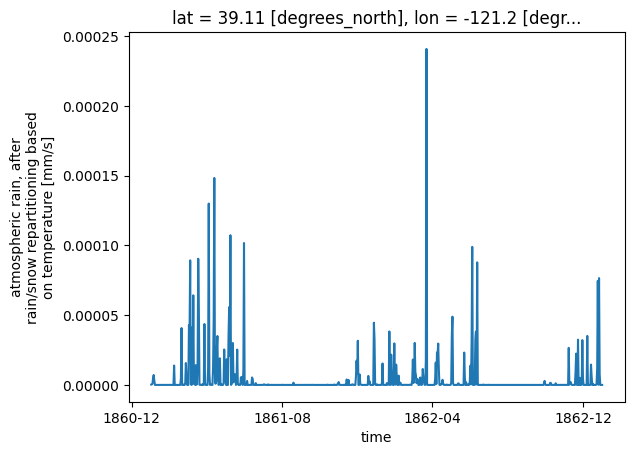

In [21]:
# lat, lon are using the i, j coordinates from the map above.
pcp_pt = dat['RAIN'].isel(lat=j, lon=i).compute()

pcp_pt.plot()

Collect data for a wet year and dry year, save to pandas for futher analysis.

In [88]:
dat = cmip.sel(time=slice('1861-01-01', '1862-12-31')).isel(member_id=1)
dat['time'] = dat.indexes['time'].to_datetimeindex()
df_wet = dat.to_dataframe()
df_wet.reset_index(inplace=True)

dat = cmip.sel(time=slice('1895-01-01', '1896-12-31')).isel(member_id=1)
dat['time'] = dat.indexes['time'].to_datetimeindex()
df_dry = dat.to_dataframe()
df_dry.reset_index(inplace=True)

/var/folders/6l/9spwppmn3gxfld10q9_szx5h0000gp/T/ipykernel_25062/3812603268.py:2: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  dat['time'] = dat.indexes['time'].to_datetimeindex()
/var/folders/6l/9spwppmn3gxfld10q9_szx5h0000gp/T/ipykernel_25062/3812603268.py:7: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  dat['time'] = dat.indexes['time'].to_datetimeindex()


Determine if each grid cell received rainfall using a threshold. If rainfall exists, set the value to 1 otherwise set the value to 0.

In [89]:
# Compute HAS_RAIN 1 of the value of RAIN is > 0, otherwise set it to 0
df_wet['HAS_RAIN'] = 0
df_wet.loc[df_wet.RAIN > 0.0, 'HAS_RAIN'] = 1

df_dry['HAS_RAIN'] = 0
df_dry.loc[df_dry.RAIN > 0.0, 'HAS_RAIN'] = 1

# has_rain = (dat['RAIN'] > 0).astype(int)

Compute the total number of days that contained rainfall within a specified period. Use a rolling window because we don't know the start date of the event.

In [90]:
# using 45 days because the 1861 storm consisted of ~45 days
number_of_days = 45

df_wet['ROLLING_45'] = df_wet.rolling(number_of_days,
                                      min_periods=number_of_days,
                                      on='HAS_RAIN').HAS_RAIN.sum()

df_dry['ROLLING_45'] = df_dry.rolling(number_of_days,
                                      min_periods=number_of_days,
                                      on='HAS_RAIN').HAS_RAIN.sum()                     

Plot a rolling window of rainy days for a known wet period (1861 - 1862). Plot the rain rate for all cells within our domain through time.

Let's do the same thing for a known dry period of time (1895 - 1897). We expect to see a stark difference between the two of these.

Comparing the *wet* and *dry* years illustrates that using the number of days that contain rain (within a specified window) is not a sufficient indicator for ArkStorm conditions. 

2024-08-27 11:36:12,216 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2024-08-27 11:36:14,788 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2024-08-27 11:36:17,047 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2024-08-27 11:36:19,704 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2024-08-27 11:36:21,804 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2024-08-27 11:36:23,797 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


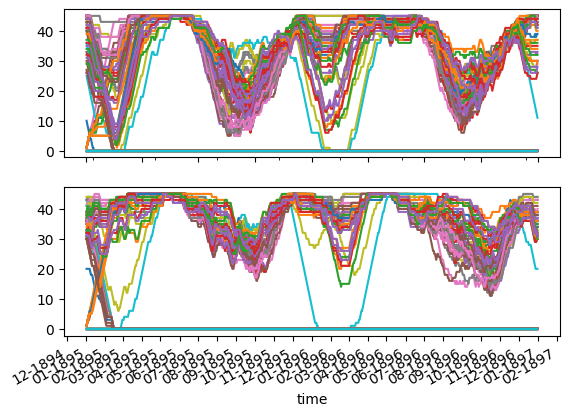

In [91]:
fig, ax = plt.subplots(nrows=2, ncols=1)

# plot wet year
for name, group in df_wet.groupby(['lat', 'lon']):
    label = ''
    group.plot(x='time', y='ROLLING_45', label=label, ax=ax[0], sharex=True)
ax[0].get_legend().remove()

# plot dry year
for name, group in df_dry.groupby(['lat', 'lon']):
    label = ''
    group.plot(x='time', y='ROLLING_45', label=label, ax=ax[1])
ax[1].get_legend().remove()

import matplotlib.dates as mdates
ax[1].xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
fig.autofmt_xdate()

This could be because some of the days that witnessed rain in very small quantities. To better illustrate this, we'll align these two datasets based on their day of year and compute the difference.

In [94]:
# Make sure that these datasets contain the same number of elements, i.e. no leap days or missing values.
assert len(df_wet) == len(df_dry)

# create a new dataframe that merges these data along their index
merged_df = df_wet.copy()
merged_df.rename(columns={'ROLLING_45':'ROLLING_WET'}, inplace=True)
merged_df['ROLLING_DRY'] = df_dry['ROLLING_45']
merged_df['Diff'] = merged_df['ROLLING_WET'] - merged_df['ROLLING_DRY']

2024-08-27 11:38:33,154 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


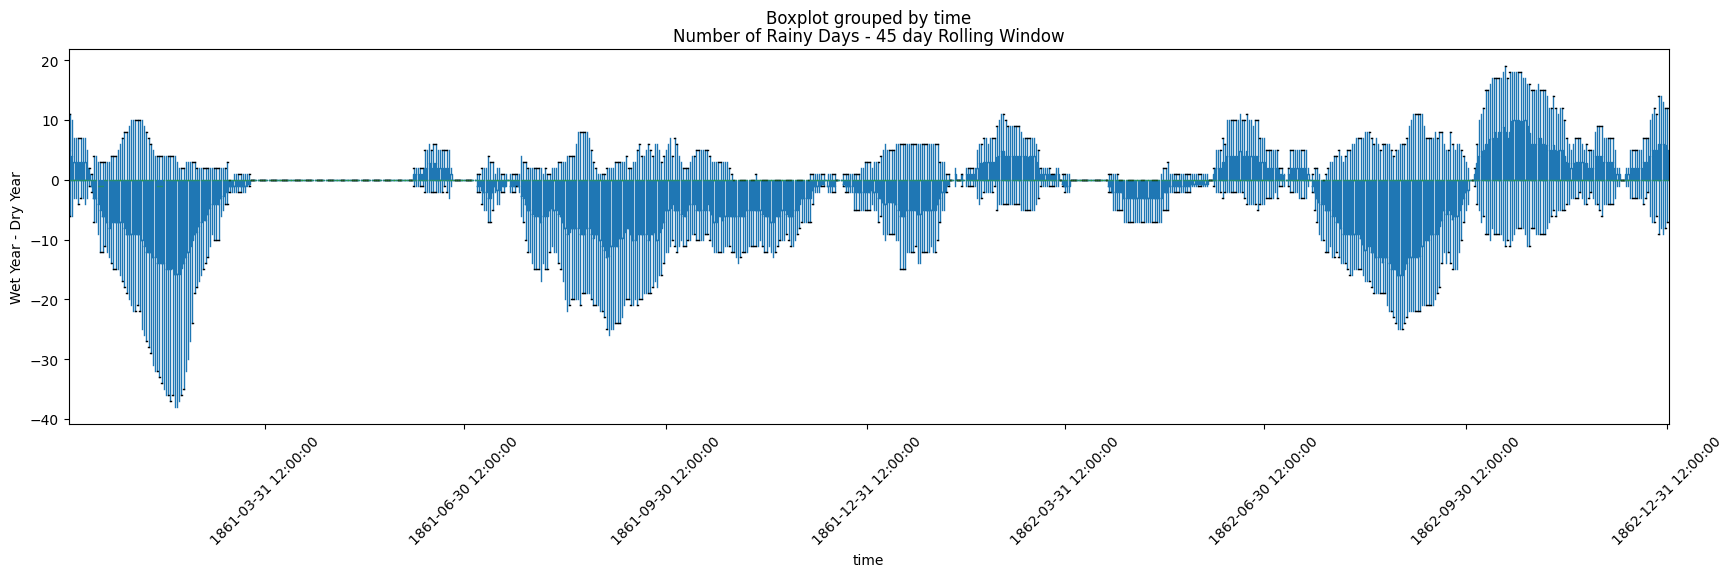

In [95]:
ax = merged_df.boxplot(column='Diff', by='time', figsize=(20, 5), rot=45, showfliers=False, grid=False);
ax.set_ylabel('Wet Year - Dry Year');
ax.set_title('Number of Rainy Days - 45 day Rolling Window')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, interval=3));

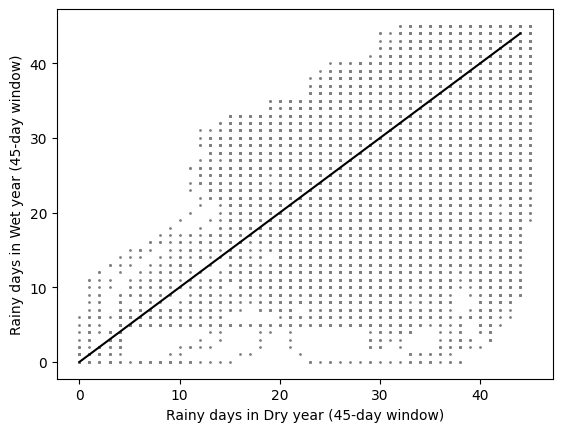

In [128]:
fig, ax = plt.subplots()

for name, group in merged_df.groupby(['lat', 'lon']):
    xdat = group['ROLLING_DRY'].sort_index()
    ydat = group['ROLLING_WET'].sort_index()
    ax.plot(xdat, ydat, linestyle='None', marker='.', ms=2, mec='grey' )

ax.plot(range(0,45), range(0,45), color='black')
ax.set_xlabel('Rainy days in Dry year (45-day window)');
ax.set_ylabel('Rainy days in Wet year (45-day window)');

In [126]:
import numpy as np
import matplotlib.pyplot as plt

x = []
y = []
for name, group in merged_df.groupby(['lat', 'lon']):
    x.extend(np.nan_to_num(group['ROLLING_DRY'].sort_index().values))
    y.extend(np.nan_to_num(group['ROLLING_WET'].sort_index().values))
    #ax.plot(xdat, ydat, linestyle='None', marker='.', ms=2, mec='grey' )

#plt.hist2d(x,y,bins=100)
#plt.show()

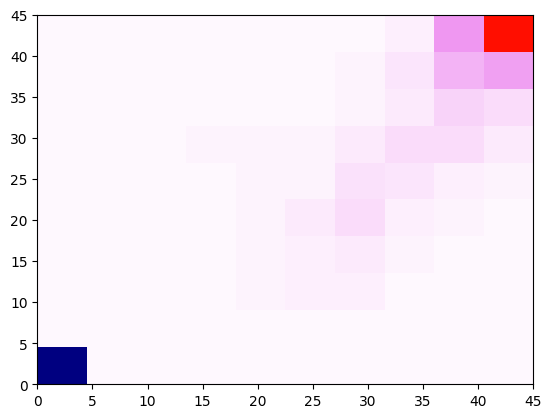

In [149]:
plt.hist2d(x,y,bins=10, cmap='gist_ncar_r')
plt.show()

In the plots above, we would expect to see a positive bias in the data. That is, we expect there to be more rainy days occuring in a wet year than in a dry year. This could be skewed by the extent of our domain as well as the presence of numerous days containing very small rain rates.

Let's see what happens if we do a similar comparison for a single grid cell.

In [153]:
# get data for the rainy year - grid cell i=2, j=8 (see map above)
ds_wet = cmip.sel(time=slice('1861-01-01', '1862-12-31')).isel(member_id=1, lat=j, lon=i)
df_wet = ds_wet.to_dataframe()

# get data for the rainy year - grid cell i=2, j=8 (see map above)
ds_dry = cmip.sel(time=slice('1895-01-01', '1896-12-31')).isel(member_id=1, lat=j, lon=i)
df_dry = ds_dry.to_dataframe()

In [154]:
# compute has_rain
df_wet['HAS_RAIN'] = (df_wet['RAIN'] > 0).astype(int)
df_dry['HAS_RAIN'] = (df_dry['RAIN'] > 0).astype(int)

# using 45 days because the 1861 storm consisted of ~45 days
number_of_days = 45
rolling_wet = df_wet['HAS_RAIN'].rolling(number_of_days).sum().reset_index()
rolling_dry = df_dry['HAS_RAIN'].rolling(number_of_days).sum().reset_index()


In [155]:
len(rolling_wet) == len(rolling_dry)

True

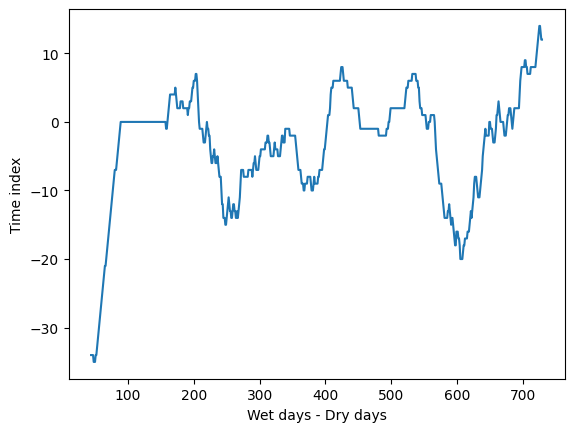

In [156]:
fig, ax = plt.subplots()

(rolling_wet['HAS_RAIN'] - rolling_dry['HAS_RAIN']).plot(ax=ax);
ax.set_xlabel('Wet days - Dry days')
ax.set_ylabel('Time index');


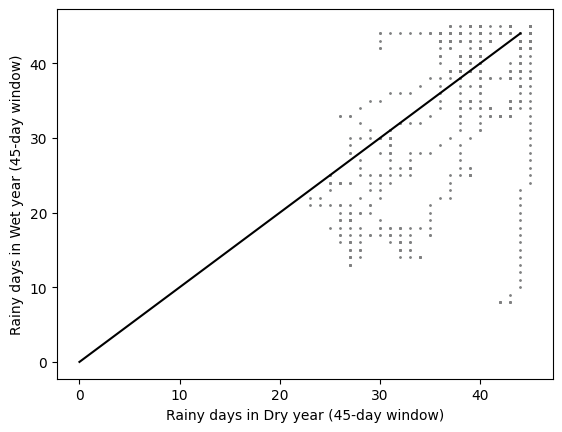

In [158]:
fig, ax = plt.subplots()

ax.plot(rolling_dry['HAS_RAIN'], rolling_wet['HAS_RAIN'], marker='.', linestyle='None', ms=2, mec='grey')
ax.plot(range(0,45), range(0,45), color='black')

ax.set_xlabel('Rainy days in Dry year (45-day window)');
ax.set_ylabel('Rainy days in Wet year (45-day window)');

It's still not clear that a wet year contains more rainy days than a dry year. Let's add a threshold to filter out days in which small amounts of rainfall occurred.

In [159]:
df_wet['RAIN mm/day'] = df_wet['RAIN'] * 86400
df_dry['RAIN mm/day'] = df_dry['RAIN'] * 86400

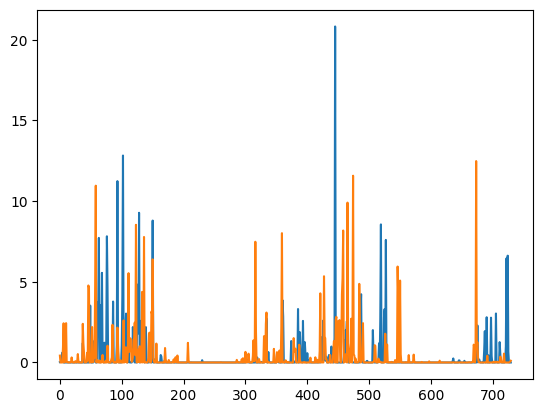

In [160]:
df_wet.reset_index()['RAIN mm/day'].plot();
df_dry.reset_index()['RAIN mm/day'].plot();

In [161]:
threshold = 1

In [162]:
# lazy compute has_rain
df_wet['HAS_RAIN_THRESHOLD'] = (df_wet['RAIN mm/day'] > threshold).astype(int)
df_dry['HAS_RAIN_THRESHOLD'] = (df_dry['RAIN mm/day'] > threshold).astype(int)

# using 45 days because the 1861 storm consisted of ~45 days
number_of_days = 45
rolling_wet = df_wet['HAS_RAIN_THRESHOLD'].rolling(number_of_days).sum().reset_index()
rolling_dry = df_dry['HAS_RAIN_THRESHOLD'].rolling(number_of_days).sum().reset_index()

In [163]:
len(rolling_wet) == len(rolling_dry)

True

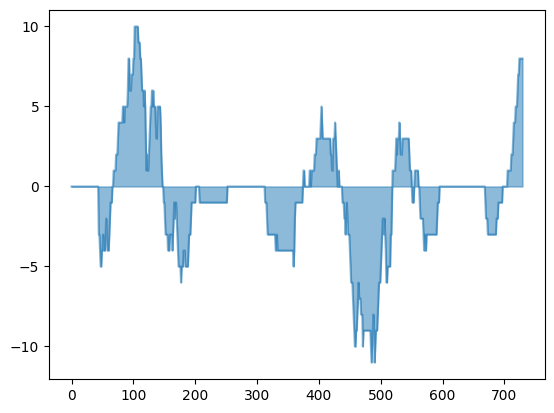

In [172]:
(rolling_wet['HAS_RAIN_THRESHOLD'] - rolling_dry['HAS_RAIN_THRESHOLD']).plot(kind='area', stacked=False);

In [165]:
df_wet['RAIN mm/day'].sum() - df_dry['RAIN mm/day'].sum()

-14.093034649210097

In [166]:
df_wet.reset_index()

,time,lat,lon,member_id,spatial_ref,RAIN,HAS_RAIN,RAIN mm/day,HAS_RAIN_THRESHOLD
0,1861-01-01 12:00:00,39.109947,-121.25,r10i1251p1f1,0,2.411887e-07,1,2.083870e-02,0
1,1861-01-02 12:00:00,39.109947,-121.25,r10i1251p1f1,0,3.693075e-07,1,3.190816e-02,0
2,1861-01-03 12:00:00,39.109947,-121.25,r10i1251p1f1,0,8.363009e-07,1,7.225640e-02,0
3,1861-01-04 12:00:00,39.109947,-121.25,r10i1251p1f1,0,4.969582e-06,1,4.293719e-01,0
4,1861-01-05 12:00:00,39.109947,-121.25,r10i1251p1f1,0,7.095339e-06,1,6.130373e-01,0
...,...,...,...,...,...,...,...,...,...
725,1862-12-27 12:00:00,39.109947,-121.25,r10i1251p1f1,0,7.769923e-06,1,6.713214e-01,0
726,1862-12-28 12:00:00,39.109947,-121.25,r10i1251p1f1,0,6.293470e-18,1,5.437558e-13,0
727,1862-12-29 12:00:00,39.109947,-121.25,r10i1251p1f1,0,0.000000e+00,0,0.000000e+00,0
728,1862-12-30 12:00:00,39.109947,-121.25,r10i1251p1f1,0,0.000000e+00,0,0.000000e+00,0


In [167]:
df_dry.reset_index()

,time,lat,lon,member_id,spatial_ref,RAIN,HAS_RAIN,RAIN mm/day,HAS_RAIN_THRESHOLD
0,1895-01-01 12:00:00,39.109947,-121.25,r10i1251p1f1,0,4.915685e-06,1,0.424715,0
1,1895-01-02 12:00:00,39.109947,-121.25,r10i1251p1f1,0,3.977406e-09,1,0.000344,0
2,1895-01-03 12:00:00,39.109947,-121.25,r10i1251p1f1,0,2.110963e-10,1,0.000018,0
3,1895-01-04 12:00:00,39.109947,-121.25,r10i1251p1f1,0,0.000000e+00,0,0.000000,0
4,1895-01-05 12:00:00,39.109947,-121.25,r10i1251p1f1,0,4.287183e-10,1,0.000037,0
...,...,...,...,...,...,...,...,...,...
725,1896-12-27 12:00:00,39.109947,-121.25,r10i1251p1f1,0,0.000000e+00,0,0.000000,0
726,1896-12-28 12:00:00,39.109947,-121.25,r10i1251p1f1,0,1.842383e-09,1,0.000159,0
727,1896-12-29 12:00:00,39.109947,-121.25,r10i1251p1f1,0,2.469042e-07,1,0.021333,0
728,1896-12-30 12:00:00,39.109947,-121.25,r10i1251p1f1,0,5.968237e-07,1,0.051566,0


<div style="color:red"> More rain is occurring in a dry year...something is not right. <div>

In [168]:
(df_wet['RAIN mm/day'].reset_index() - df_dry['RAIN mm/day'].reset_index())['RAIN mm/day'].sum()

-14.093034649210086

There are more rainy days in the dry year then the wet year

In [173]:
(rolling_wet['HAS_RAIN_THRESHOLD'] - rolling_dry['HAS_RAIN_THRESHOLD']).sum()

-414.0

In [ ]:
# Investigate a single grid cell to see if a threshold will help determine rainy time periods. Convert rainrate from mm/sec into mm/day to get a more interperetable value

# # lat, lon are using the i, j coordinates from the map above.
# pcp = dat['RAIN'].isel(lat=j, lon=i)

# # convert the datetime index into pandas datetime.
# pcp['time'] = pcp.indexes['time'].to_datetimeindex()

In [ ]:
# # Convert rain rate from mm/s to mm/day
# dat['RAIN'] = dat['RAIN'] * 86400

Investigate if a threshold will help determine rainy time periods.

In [174]:
%%time
df_daily = dat.to_dataframe()

CPU times: user 1.14 s, sys: 308 ms, total: 1.45 s
Wall time: 18.3 s


In [175]:
# reorganize the data

df_daily.reset_index(inplace=True)
df_daily

,lat,lon,time,member_id,spatial_ref,RAIN
0,32.513088,-125.00,1895-01-01 12:00:00,r10i1251p1f1,0,NaN
1,32.513088,-125.00,1895-01-02 12:00:00,r10i1251p1f1,0,NaN
2,32.513088,-125.00,1895-01-03 12:00:00,r10i1251p1f1,0,NaN
3,32.513088,-125.00,1895-01-04 12:00:00,r10i1251p1f1,0,NaN
4,32.513088,-125.00,1895-01-05 12:00:00,r10i1251p1f1,0,NaN
...,...,...,...,...,...,...
80295,41.937172,-113.75,1896-12-27 12:00:00,r10i1251p1f1,0,NaN
80296,41.937172,-113.75,1896-12-28 12:00:00,r10i1251p1f1,0,NaN
80297,41.937172,-113.75,1896-12-29 12:00:00,r10i1251p1f1,0,NaN
80298,41.937172,-113.75,1896-12-30 12:00:00,r10i1251p1f1,0,NaN


In [176]:
df_daily_grouped = df_daily.groupby(['lat', 'lon'])

Create a BoxPlot of the time series at each location, hide outliers. In this plot we see that some cells receive more rainfall than others, which is expected.

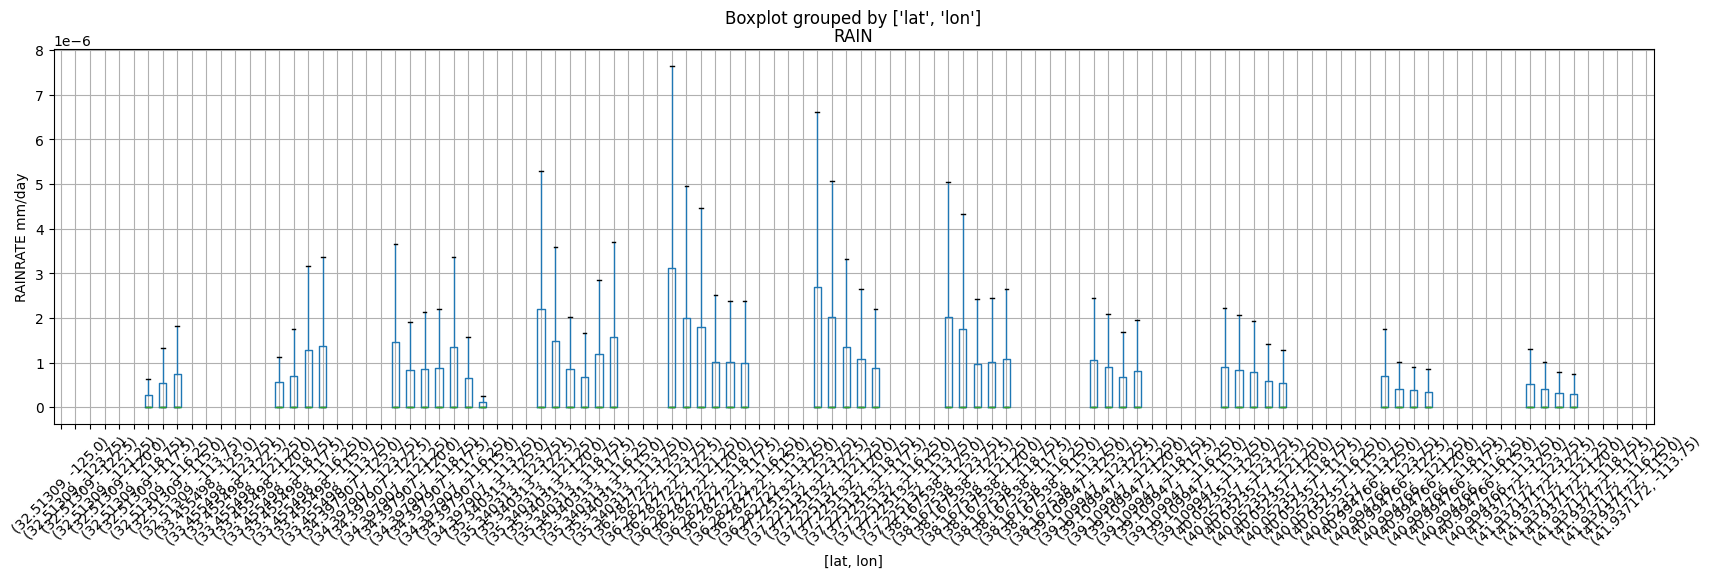

In [177]:
ax = df_daily.boxplot(column='RAIN', by=['lat', 'lon'], figsize=(20, 5), rot=45, showfliers=False);
ax.set_ylabel('RAINRATE mm/day');

Create a boxplot of all locations through time, hide outliers. In this plot we see that the rainy and dry seasons are captured.

2024-08-27 11:53:50,603 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


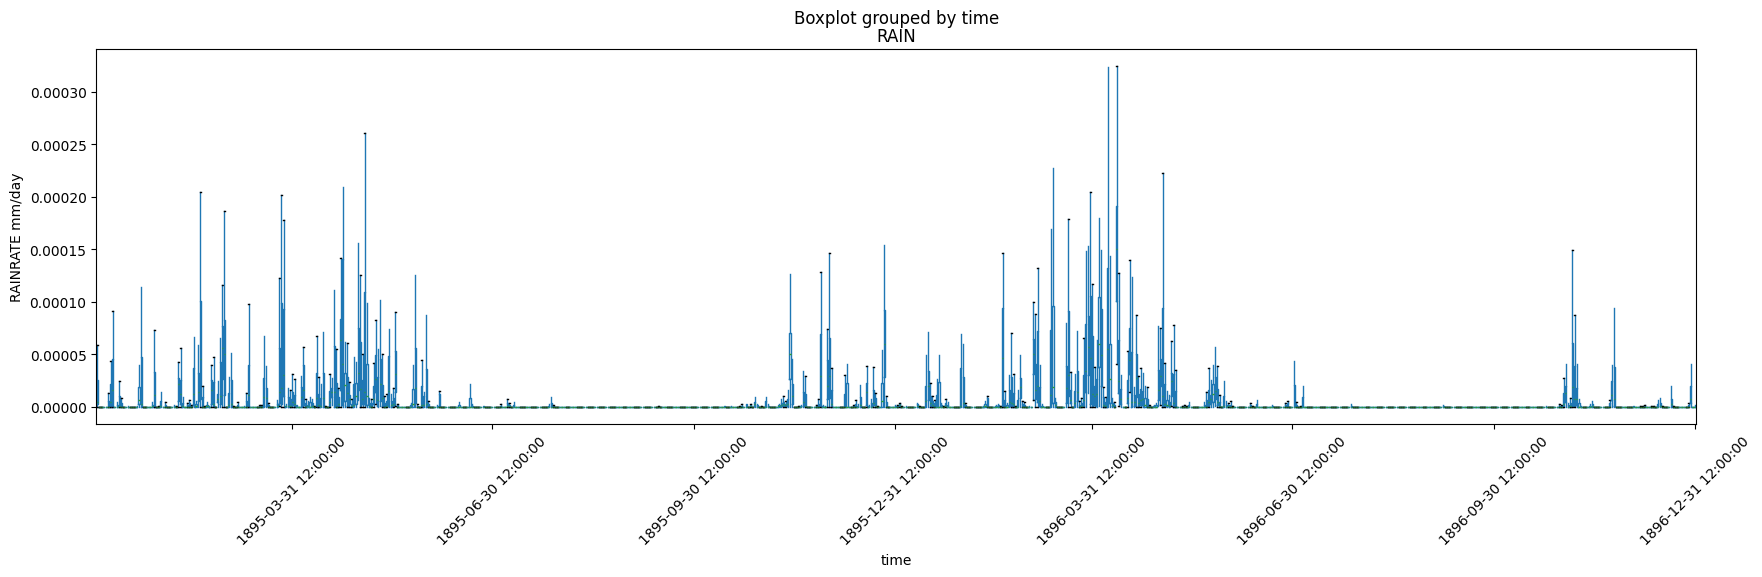

In [178]:
import matplotlib.dates as mdates

ax = df_daily.boxplot(column='RAIN', by='time', figsize=(20, 5), rot=45, showfliers=False, grid=False);
ax.set_ylabel('RAINRATE mm/day');
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, interval=3));